In [11]:
import torch
import numpy as np
from torch import Tensor
import pandas as pd
from pathlib import Path
from labproject.plotting import  place_violin

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import fontManager
from matplotlib import rc_file
rc_file("../../matplotlibrc")

from labproject.metrics.MMD_torch import *
from labproject.metrics.sliced_wasserstein import sliced_wasserstein_distance
from labproject.metrics.c2st import *
from labproject.metrics.gaussian_squared_wasserstein import gaussian_squared_w2_distance
from labproject.plotting import tiled_ticks, get_lims

import warnings
warnings.filterwarnings("ignore")

fontManager.addfont(Path(".").absolute().parent.parent / "fonts/arial.ttf")
matplotlib.rc("font", **{"family": "sans-serif", "sans-serif": "Arial"})

In [134]:
# CXR embeddings
cxr1 = torch.load('../../data/cxr/encs_real.pt')
cxr2 = torch.load('../../data/cxr/encs_fake_pggan.pt')
cxr3 = torch.load('../../data/cxr/encs_fake_stable_diffusion.pt')

# CXR real images
cxr1_real_path = Path('../../data/images')
cxr2_sd_path = Path('../../data/output')
cxr3_gan_path = Path('../../data/generated_samples')

# DDM
ddm1 = torch.load('../../data/ddm/real_data.pt')                   
ddm2 = torch.load('../../data/ddm/generated_data.pt')
ddm3 = torch.load('../../data/ddm/gaussian_data.pt')

In [221]:
cxr1.shape

torch.Size([70153, 512])

In [98]:

class Metric:
    def __init__(self, name: str, func: callable, **kwargs):
        self.name = name
        self.func = func
        self.kwargs = kwargs

    def __call__(self, x: Tensor, y: Tensor) -> Tensor:
        return self.func(x, y, **self.kwargs)
    

class DistComp:
    def __init__(self, dataset_id1: Tensor, dataset_id2: Tensor, metric: Metric, 
                 n_perms: int = 100, perm_size=1000, descr=""):
        self.dataset_id1 = dataset_id1
        self.dataset_id2 = dataset_id2
        self.metric = metric
        self.n_perms = n_perms
        self.perm_size = perm_size
        self.descr = descr

        columns = [metric.name]
        self.results_df = pd.DataFrame(np.nan, index=range(self.n_perms), columns=columns)

    def run_experiment(self):
        # for i in range(self.n_perms):
        #     self.results_df.loc[i, self.metric.name] = np.random.normal()
        for i in range(self.n_perms):
            dataset_id2_perm = self.dataset_id2[torch.randperm(len(self.dataset_id2))[:self.perm_size]]
            dataset_id1_perm = self.dataset_id1[torch.randperm(len(self.dataset_id1))[:self.perm_size]]
            
            metric = self.metric(dataset_id1_perm, dataset_id2_perm)
            
            if isinstance(metric, torch.Tensor):
                metric = metric.item()
            self.results_df.loc[i, self.metric.name] = metric
        assert not np.any(np.isnan(self.results_df.values))
    
    def reformat_df(self, data):
        """
        reformat the results_df to work with seaborn plot expectations.
        """
        metric = [column_name for _, row in data.iterrows() for column_name, _ in row.items()]
        split_ind = [i for i, _ in data.iterrows() for _ in range(len(data.columns))]
        distance = [value for _, row in data.iterrows() for _, value in row.items()]

        return pd.DataFrame({"metric": metric, "distance": distance, "split_ind": split_ind})
    
    def __repr__(self):
        return f"{self.__class__.__name__}\nDescription:{self.descr}"

In [99]:
def generate_palette(hex_color, n_colors=5, saturation="light"):
    if saturation == "light":
        palette = sns.light_palette(hex_color, n_colors=n_colors, as_cmap=False)
    elif saturation == "dark":
        palette = sns.dark_palette(hex_color, n_colors=n_colors, as_cmap=False)
    return palette

color_dict = {"SW": "#cc241d", "MMD": "#eebd35", "C2ST": "#458588", "FID": "#8ec07c"}

In [139]:
datasets = {
    "ddm": {
        "metrics": [
            Metric('SW', sliced_wasserstein_distance),
            Metric('C2ST', c2st_nn),
            Metric('MMD', compute_rbf_mmd, bandwidth=0.5),
            # Metric("FID", gaussian_squared_w2_distance)
        ],
        "comparisons":[
            (ddm1, ddm1),
            (ddm1, ddm2),
            (ddm1, ddm3),
            (ddm2, ddm3),
        ],
        "descr": [
            "real vs real",
            "real vs DDM", 
            "real vs Gauss.", 
            "DDM vs Gauss.",
        ],
        "kwargs":{
            "n_perms": 10,
            "perm_size": 300
        }
    },
    "cxr": {
        "metrics": [
            Metric('SW', sliced_wasserstein_distance),
            Metric('C2ST', c2st_nn),
            Metric('MMD', compute_rbf_mmd, bandwidth=50.0),
            Metric("FID", gaussian_squared_w2_distance)
        ],
        "comparisons":[
            (cxr1, cxr1),
            (cxr1, cxr2),
            (cxr1, cxr3),
            (cxr2, cxr3),
        ],
        "descr": [
            "real vs real",
            "real vs PGGAN", 
            "real vs SD",
            "PGGAN vs SD",
        ],
        "kwargs":{
            "n_perms": 10,
            "perm_size": 1000
        },
        "paths": 
            {
                "real": cxr1_real_path,
                "SD": cxr2_sd_path,
                "PGGAN": cxr3_gan_path,
            }

    }
}  

In [101]:

experiments = {}
for dataset_id in datasets:
   n_metrics = len(datasets[dataset_id]["metrics"])
   n_comparisons = len(datasets[dataset_id]["comparisons"])
   n_perms = datasets[dataset_id]["kwargs"]["n_perms"]
   perm_size = datasets[dataset_id]["kwargs"]["perm_size"]
   experiments[dataset_id] = np.zeros([n_metrics, n_comparisons, n_perms])

   for i, metric in enumerate(datasets[dataset_id]["metrics"]):
      for j, (comp, descr) in enumerate(zip(datasets[dataset_id]["comparisons"], datasets[dataset_id]["descr"])):
            exp = DistComp(comp[0], comp[1], metric, n_perms=n_perms, perm_size=perm_size, descr=descr)
            exp.run_experiment()
            experiments[dataset_id][i, j, :] = exp.results_df.to_numpy().flatten()


-----------------------------------------------------------

In [7]:

# dataset_ids_long_name = {"ddm": "Drift diffusion data", 
#                       "cxr": "X-Ray data"}
# metrics_names = ["SW", "C2ST", "MMD", "FID"]
# dataset_id_list = ["ddm", "cxr"]
# comparisons_lists = {"ddm": ["real vs real",
#                              "real vs DDM", 
#                              #"DDM vs DDM", 
#                              "real vs Gauss.", 
#                              "DDM vs Gauss.",
#                              #"Gaussian vs Gaussian"
#                              ], 
#                      "cxr": ["real vs real", 
#                              "real vs PGGAN", 
#                              #"PGGAN vs PGGAN", 
#                              "real vs SD", 
#                              "PGGAN vs SD",
#                              #"Stable Diffusion vs Stable Diffusion"
#                              ]}

## DDM plots 

In [15]:
from labproject.plotting import cm2inch

In [17]:
dataset_id

'cxr'

tensor([0.5310, 0.5150, 0.2840, 0.2860, 0.2280, 0.5790, 0.2670, 0.3110, 0.4240,
        0.2980, 0.5070, 0.5260, 0.2090, 0.2690, 0.2730, 0.2790, 0.3040, 0.2810,
        0.2290, 0.2860, 0.4920, 0.5040, 0.4460, 0.6390, 0.3520, 0.4230, 0.4540,
        0.3120, 0.2990, 0.2770, 0.2890, 0.2670, 0.2690, 0.5260, 0.6820, 0.8510,
        0.5390, 0.6930, 0.6100, 0.6870, 0.3240, 0.6830, 0.3390, 0.4910, 0.5520,
        0.2850, 0.6290, 0.5130, 0.7260, 0.8190, 0.4540, 0.3490, 0.4340, 0.5430,
        0.5180, 0.3820, 0.6500, 0.3610, 0.4980, 0.5170, 0.3810, 0.6740, 0.6430,
        0.4440, 0.5820, 0.3550, 0.4110, 0.2980, 0.3110, 0.6040, 0.4480, 0.6090,
        0.6170, 0.8640, 0.5220, 0.4990, 0.8070, 0.4820, 0.5480, 0.8840, 0.3950,
        0.5870, 0.5650, 0.5860, 0.5560, 0.5230, 0.5170, 0.5480, 0.6520, 0.7720,
        0.8260, 0.4990, 0.6570, 0.6400, 0.9410, 0.7990, 0.5830, 0.6800, 0.5250,
        0.6290, 0.3050, 0.8370, 0.5370, 0.8370, 0.4910, 0.6110, 0.9030, 0.8250,
        0.6280, 0.5690, 0.7020, 0.6910, 

(array([0.02078425, 0.02078425, 0.0415685 , 0.06235274, 0.10392127,
        0.10392124, 0.31176371, 0.66509591, 0.93529112, 1.18470278,
        1.22627058, 1.55881762, 1.66274074, 1.76666203, 1.80822844,
        1.97450463, 1.20548563, 1.62117222, 1.33019259, 0.76901669,
        0.39490093, 0.4780374 , 0.16627388, 0.14548998, 0.0623527 ]),
 array([-0.02123031,  0.02973723,  0.08070477,  0.13167231,  0.18263985,
         0.23360738,  0.28457493,  0.33554247,  0.38651001,  0.43747756,
         0.48844507,  0.53941262,  0.59038019,  0.64134771,  0.69231522,
         0.74328279,  0.79425031,  0.84521788,  0.8961854 ,  0.94715291,
         0.99812049,  1.049088  ,  1.10005558,  1.15102315,  1.2019906 ,
         1.25295818]),
 [<matplotlib.patches.Polygon at 0x7f9988dec760>])

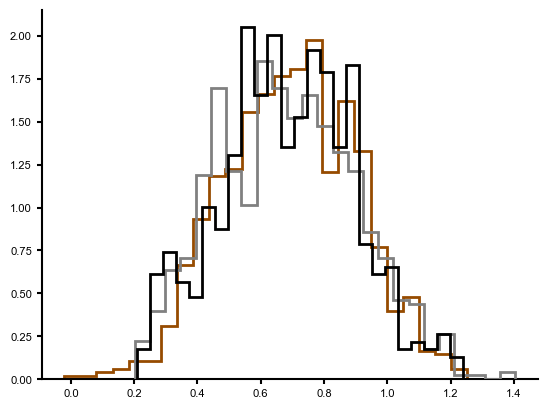

In [30]:
fig, ax = plt.subplots()


In [34]:
from labproject import plotting

In [44]:
X.shape

(1, 4)

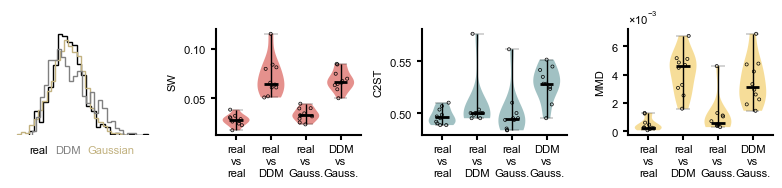

In [219]:
fig, axes = plt.subplots(1, 4, figsize=cm2inch(25, 3.5))

# Set the formatter
formatter = ticker.ScalarFormatter(useMathText=True) # Use mathematical text for scientific notation
formatter.set_scientific(True) # Enable scientific notation
formatter.set_powerlimits((-1,1)) # This will force scientific notation

dataset_id = 'ddm'
experiment = experiments[dataset_id]





ax = axes[0]
_, bins, _ = ax.hist(ddm1.flatten(), bins=25, histtype='step', lw=1, label='real', color="k", zorder=0, density=True)
ax.hist(ddm2.flatten(), bins=25, histtype='step', lw=1, label='DDM', color="0.5", zorder=10, density=True)
ax.hist(ddm3.flatten(), bins=25, histtype='step', lw=1, label='Gaussian', color="#C2B280", zorder=5, density=True)
ax.annotate("real", (0.2, -0.1), xycoords="axes fraction", color="k", ha='center', va='top', fontweight='bold')
ax.annotate("DDM", (0.4, -0.1), xycoords="axes fraction", color="0.5", ha='center', va='top', fontweight='bold')
ax.annotate("Gaussian", (0.7, -0.1), xycoords="axes fraction", color="#C2B280", ha='center', va='top', fontweight='bold')


for j, metric in enumerate(datasets[dataset_id]["metrics"]):
    for k, comparison in enumerate(datasets[dataset_id]["comparisons"]):
        X = tiled_ticks(0, 2, n_major_ticks=1, n_minor_ticks=len(datasets[dataset_id]["comparisons"]), offset=0.175)
        x, Y = X[0][k], experiment[j, k]
        ax = axes[j + 1]
        body_colors = generate_palette(color_dict[metrics_names[j]], n_colors=n_comparisons)
        place_violin(ax, x, Y, 
                        scatter_face_color="none",
                    scatter_edge_color="k",
                    scatter_lw=0.5,
                    scatter_radius=5,
                    scatter_alpha=1,
                    scatter_width=0.5,
                    scatter=True,
                    scatter_zorder=3,
                    width=0.09, 
                    median_color='k', #color_dict[metrics_names[i]],
                    median_bar_length=0.5, 
                    median_lw=2, 
                    whisker_color='k', #color_dict[metrics_names[i]],
                    whisker_alpha=1, 
                    whisker_lw=1,
                    median_alpha=1,
                    #    body_face_color=body_colors[k])
                    body_face_color=color_dict[metrics_names[j]],
                    body_edge_color="none",
                    body_alpha=0.5)

# # cosmetics
ylabels = ["", "SW", "C2ST", "MMD", "FID"]

for column, ax in enumerate(axes):
        
    # remove first axis spines
    if column == 0:
        plotting.rm_spines(ax)

    else:
        ax.set_ylabel(ylabels[column])
        ax.yaxis.set_major_formatter(formatter)
        
        xticklabel = [xtl.split(" vs ") for xtl in datasets[dataset_id]["descr"]]
        xticklabel = ["\nvs\n".join(xtl) for xtl in xticklabel] 
        ax.set_xticks(X[0], xticklabel, rotation=0)

    ax.patch.set_alpha(0)

plt.subplots_adjust(wspace=0.425)

plt.savefig("application_01_ddm.pdf", bbox_inches="tight", transparent=True)

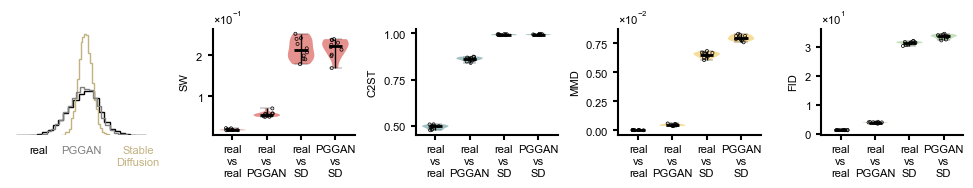

In [218]:
fig, axes = plt.subplots(1, 5, figsize=cm2inch(25 + 6.25, 3.5))

# Set the formatter
formatter = ticker.ScalarFormatter(useMathText=True) # Use mathematical text for scientific notation
formatter.set_scientific(True) # Enable scientific notation
formatter.set_powerlimits((-1,1)) # This will force scientific notation

dataset_id = 'cxr'
experiment = experiments[dataset_id]


ax = axes[0]
_, bins, _ = ax.hist(cxr1.mean(axis=1), bins=25, histtype='step', lw=1, label='real', color="k", zorder=0, density=True)
ax.hist(cxr2.mean(axis=1), bins=25, histtype='step', lw=1, label='PGGAN', color="0.5", zorder=10, density=True)
ax.hist(cxr3.mean(axis=1), bins=25, histtype='step', lw=1, label='Stable Diffusion', color="#C2B280", zorder=5, density=True)
ax.annotate("real", (0.2, -0.1), xycoords="axes fraction", color="k", ha='center', va='top', fontweight='bold')
ax.annotate("PGGAN", (0.5, -0.1), xycoords="axes fraction", color="0.5", ha='center', va='top', fontweight='bold')
ax.annotate("Stable\nDiffusion", (0.9, -0.1), xycoords="axes fraction", color="#C2B280", ha='center', va='top', fontweight='bold')


for j, metric in enumerate(datasets[dataset_id]["metrics"]):
    for k, comparison in enumerate(datasets[dataset_id]["comparisons"]):
        X = tiled_ticks(0, 2, n_major_ticks=1, n_minor_ticks=len(datasets[dataset_id]["comparisons"]), offset=0.175)
        x, Y = X[0][k], experiment[j, k]
        ax = axes[j + 1]
        body_colors = generate_palette(color_dict[metrics_names[j]], n_colors=n_comparisons)
        place_violin(ax, x, Y, 
                        scatter_face_color="none",
                    scatter_edge_color="k",
                    scatter_lw=0.5,
                    scatter_radius=5,
                    scatter_alpha=1,
                    scatter_width=0.5,
                    scatter=True,
                    scatter_zorder=3,
                    width=0.09, 
                    median_color='k', #color_dict[metrics_names[i]],
                    median_bar_length=0.5, 
                    median_lw=2, 
                    whisker_color='k', #color_dict[metrics_names[i]],
                    whisker_alpha=1, 
                    whisker_lw=1,
                    median_alpha=1,
                    #    body_face_color=body_colors[k])
                    body_face_color=color_dict[metrics_names[j]],
                    body_edge_color="none",
                    body_alpha=0.5)

# # cosmetics
ylabels = ["", "SW", "C2ST", "MMD", "FID"]

for column, ax in enumerate(axes):
        
    # remove first axis spines
    if column == 0:
        plotting.rm_spines(ax)

    else:
        ax.set_ylabel(ylabels[column])
        ax.yaxis.set_major_formatter(formatter)
        
        xticklabel = [xtl.split(" vs ") for xtl in datasets[dataset_id]["descr"]]
        xticklabel = ["\nvs\n".join(xtl) for xtl in xticklabel] 
        ax.set_xticks(X[0], xticklabel, rotation=0)

    if column == 2:
        ax.set_yticks([0.5, 0.75, 1.0])

    ax.patch.set_alpha(0)

plt.subplots_adjust(wspace=0.425)
plt.savefig("application_01_cxr.pdf", bbox_inches="tight", transparent=True)

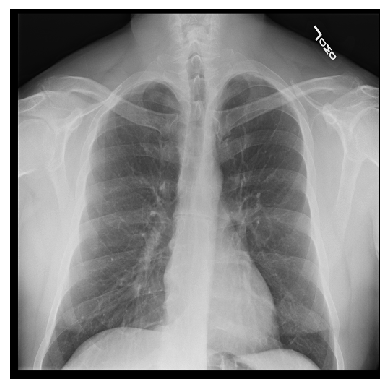

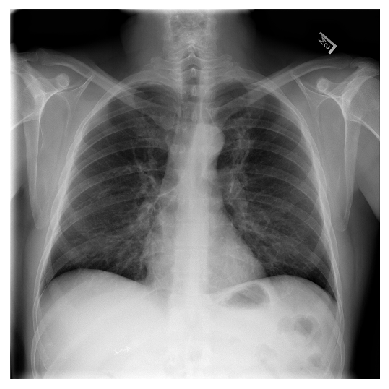

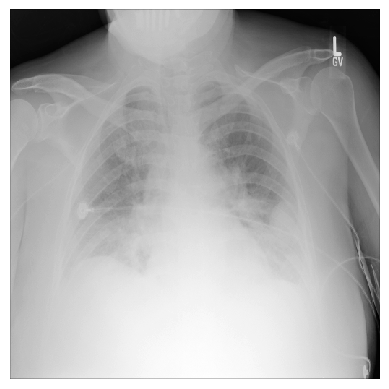

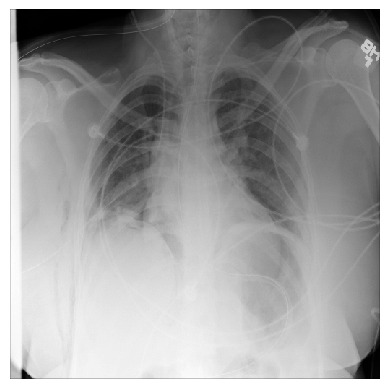

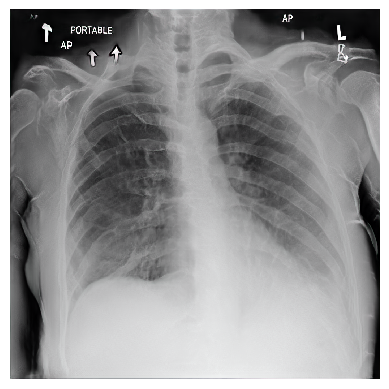

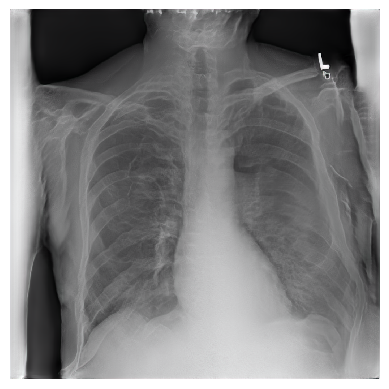

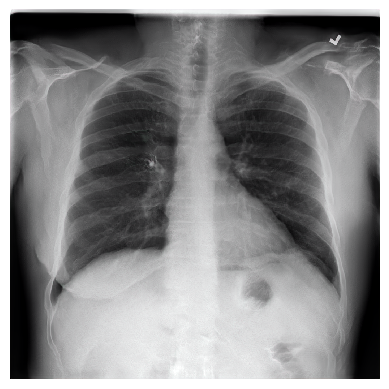

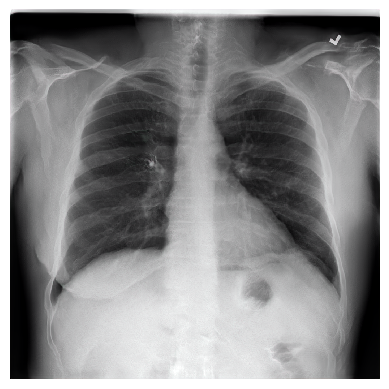

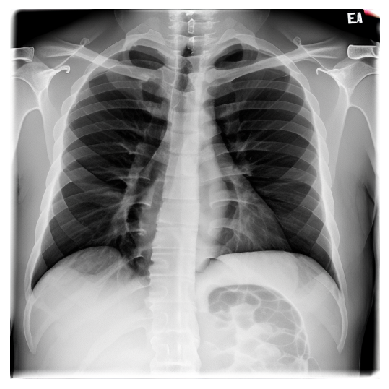

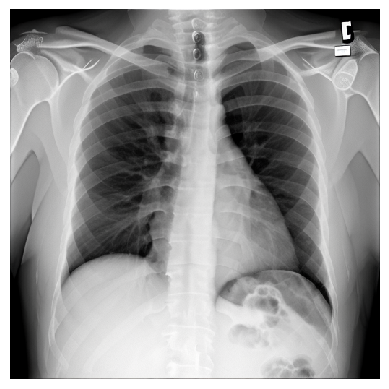

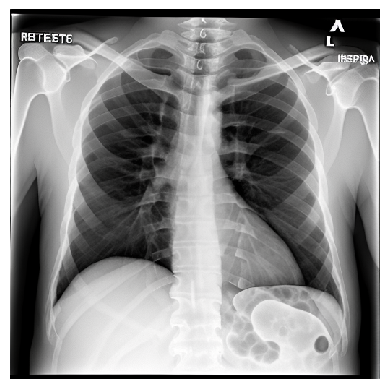

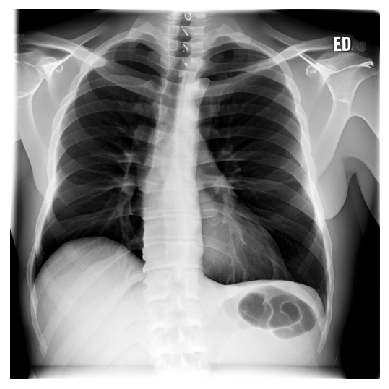

In [162]:
import os
import matplotlib.image as mpimg

real_path = Path('../../data/images')
sd_path = Path('../../data/output')
gan_path = Path('../../data/generated_samples')

np.random.seed(0)

def load_image(images_path, image_name):
    return mpimg.imread(os.path.join(images_path, image_name))

def load_random_image_from(path, random):
    images = list(path.iterdir())
    idx = random.choice(list(range(len(images))))
    return load_image(path, images[idx])


random = np.random.RandomState(42)
for i, dist in enumerate(["real", "PGGAN", "SD"]):
    for j in range(1, 5):
        fig, ax = plt.subplots()
        image = load_random_image_from(datasets[dataset_id]["paths"][dist],
                                       random)
        if image.max() > 1:
            image = image / 255.
        ax.imshow(image, cmap=plt.cm.binary_r)
        plotting.rm_spines(ax)
        fig.savefig(f"xray_{dist}_{j}.pdf", bbox_inches="tight", transparent=True)

In [163]:
mosaic = np.array([["A", "A", "real.1", "real.2", "PGGAN.1", "PGGAN.2", "SD.1", "SD.2"], 
          ["A", "A", "real.3", "real.4", "PGGAN.3", "PGGAN.4", "SD.3", "SD.4"],
          ["SW", "SW", "C2ST", "C2ST", "MMD", "MMD", "FID", "FID"],
          ["SW", "SW", "C2ST", "C2ST", "MMD", "MMD", "FID", "FID"]])

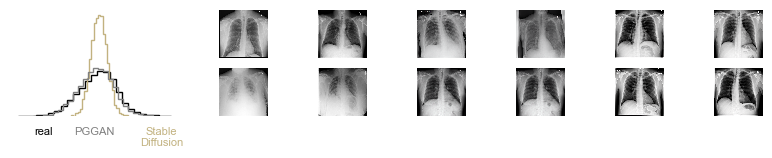

In [216]:
fig, axes = plt.subplot_mosaic(mosaic[0:2], figsize=cm2inch(25, 3.5))

# Set the formatter
formatter = ticker.ScalarFormatter(useMathText=True) # Use mathematical text for scientific notation
formatter.set_scientific(True) # Enable scientific notation
formatter.set_powerlimits((-1,1)) # This will force scientific notation

dataset_id = 'cxr'
experiment = experiments[dataset_id]


ax = axes["A"]
_, bins, _ = ax.hist(cxr1.mean(axis=1), bins=25, histtype='step', lw=1, label='real', color="k", zorder=0, density=True)
ax.hist(cxr2.mean(axis=1), bins=25, histtype='step', lw=1, label='PGGAN', color="0.5", zorder=10, density=True)
ax.hist(cxr3.mean(axis=1), bins=25, histtype='step', lw=1, label='Stable Diffusion', color="#C2B280", zorder=5, density=True)
ax.annotate("real", (0.2, -0.1), xycoords="axes fraction", color="k", ha='center', va='top', fontweight='bold')
ax.annotate("PGGAN", (0.5, -0.1), xycoords="axes fraction", color="0.5", ha='center', va='top', fontweight='bold')
ax.annotate("Stable\nDiffusion", (0.9, -0.1), xycoords="axes fraction", color="#C2B280", ha='center', va='top', fontweight='bold')
plotting.rm_spines(ax)

random = np.random.RandomState(42)
for i, dist in enumerate(["real", "PGGAN", "SD"]):
    for j in range(1, 5):
        key = f"{dist}.{j}"
        ax = axes[key]
        image = load_random_image_from(datasets[dataset_id]["paths"][dist],
                                       random)
        if image.max() > 1:
            image = image / 255.
        ax.imshow(image, cmap=plt.cm.binary_r)
        plotting.rm_spines(ax)        

plt.subplots_adjust(wspace=0.425)
plt.savefig("application_01_cxr_v2_top_row.pdf", bbox_inches="tight", transparent=True)

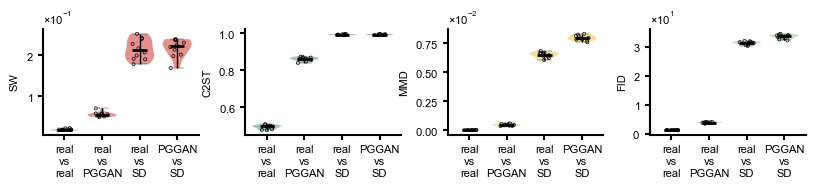

In [217]:
fig, axes = plt.subplot_mosaic(mosaic[2:4], figsize=cm2inch(25, 3.5))

# Set the formatter
formatter = ticker.ScalarFormatter(useMathText=True) # Use mathematical text for scientific notation
formatter.set_scientific(True) # Enable scientific notation
formatter.set_powerlimits((-1,1)) # This will force scientific notation

dataset_id = 'cxr'
experiment = experiments[dataset_id]
   

ylabels = ["SW", "C2ST", "MMD", "FID"]


for j, metric in enumerate(datasets[dataset_id]["metrics"]):
    for k, comparison in enumerate(datasets[dataset_id]["comparisons"]):
        X = tiled_ticks(0, 2, n_major_ticks=1, n_minor_ticks=len(datasets[dataset_id]["comparisons"]), offset=0.175)
        x, Y = X[0][k], experiment[j, k]
        ax = axes[metric.name]
        body_colors = generate_palette(color_dict[metrics_names[j]], n_colors=n_comparisons)
        place_violin(ax, x, Y, 
                        scatter_face_color="none",
                    scatter_edge_color="k",
                    scatter_lw=0.5,
                    scatter_radius=5,
                    scatter_alpha=1,
                    scatter_width=0.5,
                    scatter=True,
                    scatter_zorder=3,
                    width=0.09, 
                    median_color='k', #color_dict[metrics_names[i]],
                    median_bar_length=0.5, 
                    median_lw=2, 
                    whisker_color='k', #color_dict[metrics_names[i]],
                    whisker_alpha=1, 
                    whisker_lw=1,
                    median_alpha=1,
                    #    body_face_color=body_colors[k])
                    body_face_color=color_dict[metrics_names[j]],
                    body_edge_color="none",
                    body_alpha=0.5)

        ax.set_ylabel(ylabels[j])
        ax.yaxis.set_major_formatter(formatter)
        
        xticklabel = [xtl.split(" vs ") for xtl in datasets[dataset_id]["descr"]]
        xticklabel = ["\nvs\n".join(xtl) for xtl in xticklabel] 
        ax.set_xticks(X[0], xticklabel, rotation=0)

        ax.patch.set_alpha(0)

plt.subplots_adjust(wspace=0.425 * 2)
plt.savefig("application_01_cxr_v2_bottom_row.pdf", bbox_inches="tight", transparent=True)

In [220]:
!zip plots.zip *.pdf

updating: application_01_cxr.pdf (deflated 18%)
updating: application_01_cxr_v2_bottom_row.pdf (deflated 17%)
updating: application_01_cxr_v2_top_row.pdf (deflated 2%)
updating: application_01_ddm.pdf (deflated 18%)
updating: distances_violin.pdf (deflated 17%)
updating: figure_application_2_xray_examples.pdf (deflated 2%)
updating: gamma.pdf (deflated 31%)
updating: xray_PGGAN_1.pdf (deflated 0%)
updating: xray_PGGAN_2.pdf (deflated 0%)
updating: xray_PGGAN_3.pdf (deflated 0%)
updating: xray_PGGAN_4.pdf (deflated 0%)
updating: xray_real_1.pdf (deflated 2%)
updating: xray_real_2.pdf (deflated 2%)
updating: xray_real_3.pdf (deflated 2%)
updating: xray_real_4.pdf (deflated 2%)
updating: xray_SD_1.pdf (deflated 1%)
updating: xray_SD_2.pdf (deflated 2%)
updating: xray_SD_3.pdf (deflated 2%)
updating: xray_SD_4.pdf (deflated 2%)
